In [98]:
#import torch
import pandas as pd
import shapely
import numpy as np
import sys
#import torch
import argparse
import random
import math
import os
import warnings
from shapely.geometry import LineString, Polygon
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler # 好处在于可以保存训练集中的参数（均值、方差）
from scipy.stats import stats
#from torch.utils.data import DataLoader
#from torch.optim import lr_scheduler
import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# Version 1
Seq to seq model: target use the scores + high + use rate

In [2]:
# read file
#data = pd.read_pickle('../data/thread_0_0_999.pkl')
data = pd.read_pickle('../results/new_sample.tmp')

## prepare the data
what kinds of data do we need
- vector representation of the 'Teile' 
- vector representation of the rotation
- number of knote in the Teile
- normalized area of teile
- normalized circle of teile
- normlized area/circle of teile
- normalized left down of teile
- normalized right down of teile
- normalized area/circle after convexing
- normalized length/width
- normalized centroid x/width
- normalized centroid y/length

In [5]:
df.head()

,Jobid,Rot,List of Coordinates,Shapely Polygon,Metric1,Metric2,Metric3,Metric4,Area,Length,Left down,score,right down
16,92600-1250_7_16,0.00,"[(0.0, 9.0), (9.0, 0.0), (115.8, 0.0), (124.8,...","POLYGON ((0 9, 9 0, 115.8 0, 124.8 9, 124.8 45...",17.00,132.00,849.00,5.00,4439.800,615.763,"(256.8, 849.0)",0.500,"(256.8, 903.5)"
17,92600-1250_7_17,90.00,"[(0.0, 9.0), (9.0, 0.0), (115.8, 0.0), (124.8,...","POLYGON ((0 9, 9 0, 115.8 0, 124.8 9, 124.8 45...",18.00,288.00,1354.00,4.00,4439.800,615.763,"(342.5, 1354.0)",4.000,"(342.5, 1478.8)"
18,92600-1250_7_18,90.00,"[(1.0, 123.3), (0.0, 122.3), (0.0, 93.3), (1.0...","POLYGON ((1 123.3, 0 122.3, 0 93.3, 1 92.3, 21...",19.00,386.00,1352.00,4.00,7228.382,901.580,"(509.3, 1352.0)",4.000,"(509.3, 1455.6)"
19,92600-1250_7_19,90.00,"[(6.0, 38.0), (7.1, 40.0), (97.5, 40.0), (98.7...","POLYGON ((6 38, 7.1 40, 97.5 40, 98.7 38, 98.7...",20.00,135.00,1186.00,2.00,23178.165,1448.933,"(175.0, 1186.0)",0.000,"(175.0, 1874.3)"
20,92600-1250_7_20,90.00,"[(28.5, 0.0), (60.1, 0.0), (84.4, 7.9), (88.3,...","POLYGON ((28.5 0, 60.1 0, 84.40000000000001 7....",21.00,491.00,1466.00,4.00,1103.760,192.719,"(511.0, 1466.0)",4.000,"(511.0, 1554.3)"


In [6]:
# get unique type of shapely
polygon1 = df["Shapely Polygon"].iloc[0]
polygon2 = df["Shapely Polygon"].iloc[2]
polygon3 = df["Shapely Polygon"].iloc[3]
polygon4 = df["Shapely Polygon"].iloc[4]
polygon5 = df["Shapely Polygon"].iloc[15]
polygon6 = df["Shapely Polygon"].iloc[28]

In [7]:
# get features: area_quote, convec_area_quote
polygon_list = [polygon1,polygon2,polygon3,polygon4,polygon5,polygon6]

def area_quote_calculation(x):
    bounds_x = x.bounds[2]
    bounds_y = x.bounds[3]
    return x.area/(bounds_x*bounds_y)

def convex_area_quote_calculation(polygon):
    convex_hull_x, convex_hull_y = [z.tolist() for z in polygon.convex_hull.exterior.coords.xy]
    convex_polygon = Polygon(zip(convex_hull_x,convex_hull_y))
    convex_area_quote = convex_polygon.area/(convex_polygon.bounds[2]*convex_polygon.bounds[3])
    return convex_area_quote

result = []
for polygon in polygon_list:
    temp=[]
    temp.append(polygon)
    temp.append(area_quote_calculation(polygon))
    temp.append(convex_area_quote_calculation(polygon))
    temp.append(polygon.centroid.x/polygon.bounds[2])
    temp.append(polygon.centroid.y/polygon.bounds[3])
    temp.append(polygon.bounds[2]/polygon.bounds[3])
    result.append(temp)

In [8]:
features  = pd.DataFrame(result,columns=["Shapely Polygon", "area quote", 
                                          "convex area quote", "centroid x/width",
                                          "centroid y/height","width/height" ] )

In [9]:
# 面积  长度   面积使用率   变成凸以后，面积使用率  复杂度？  重心  长宽比

In [10]:
# get num of corr
df['num_of_corr'] = df['Shapely Polygon'].map(lambda x: len(list(x.boundary.coords)))
features["num_of_corr"] = features["Shapely Polygon"].map(lambda x:len(list(x.boundary.coords)))
del features["Shapely Polygon"]

In [11]:
# merge features to original dataframe
df =  pd.merge(df, features, how="left", left_on="num_of_corr",right_on="num_of_corr")

In [12]:
# get onehot data for 'Teile-Nr'
df = df.reset_index().iloc[:,1:]
# get onehot data
ohe = OneHotEncoder()
tmp = ohe.fit_transform(df['num_of_corr'].values.reshape(-1, 1)).toarray()
tmp = pd.DataFrame(tmp)
tmp.columns = ['s1', 's2', 's3', 's4', 's5', 's6']
df = pd.concat([df, tmp], axis = 1)

In [ ]:
#df.isnull().values.any()

In [15]:
# get onehot data for rotation
df['Rot'][df['Rot'] == '5.00'] = '0.00'
# get onehot data
tmp = ohe.fit_transform(df['Rot'].values.reshape(-1, 1)).toarray()
tmp = pd.DataFrame(tmp)
tmp.columns = ['r1', 'r2']
df = pd.concat([df, tmp], axis = 1)

In [135]:
#df.head()

In [17]:
# change type of clumns for y
df['Metric2'] = pd.to_numeric(df['Metric2'])
df['Metric3'] = pd.to_numeric(df['Metric3'])
df['Metric4'] = pd.to_numeric(df['Metric4'])

In [18]:
# al = area /length
df['A/L'] = df['Area']/df['Length']

In [19]:
# get coordinate of echo value
df['Left_down_x'] = df['Left down'].map(lambda x: x[0])
df['Left_down_y'] = df['Left down'].map(lambda x: x[1])
df['Right_down_y'] = df['right down'].map(lambda x: x[1])

In [20]:
# normalize the area, Length, num_of_corr, Left_down_x, Left_down_y, Right_down_y, A/L ...
scaler_area = StandardScaler().fit(df['Area'].values.reshape(-1, 1))
scaler_length = StandardScaler().fit(df['Length'].values.reshape(-1, 1))
scaler_num_of_corr = StandardScaler().fit(df['num_of_corr'].values.reshape(-1, 1))
scaler_al = StandardScaler().fit(df['A/L'].values.reshape(-1, 1))

scaler_area_quote = StandardScaler().fit(df['area quote'].values.reshape(-1, 1))
scaler_convex_area_quote = StandardScaler().fit(df['convex area quote'].values.reshape(-1, 1))
scaler_centroid_x_width = StandardScaler().fit(df['centroid x/width'].values.reshape(-1, 1))
scaler_centroid_y_height = StandardScaler().fit(df['centroid y/height'].values.reshape(-1, 1))
scaler_widt_height = StandardScaler().fit(df['width/height'].values.reshape(-1, 1))

scaler_ldx = StandardScaler().fit(df['Left_down_x'].values.reshape(-1, 1))
scaler_ldy = StandardScaler().fit(df['Left_down_y'].values.reshape(-1, 1))
scaler_rdy = StandardScaler().fit(df['Right_down_y'].values.reshape(-1, 1))

In [21]:
df['norm_area'] = scaler_area.transform(df['Area'].values.reshape(-1, 1))
df['norm_length'] = scaler_length.transform(df['Length'].values.reshape(-1, 1))
df['norm_num_of_corr'] = scaler_num_of_corr.transform(df['num_of_corr'].values.reshape(-1, 1))
df['norm_A/L'] = scaler_al.transform(df['A/L'].values.reshape(-1, 1))

df['norm_area quote'] = scaler_area_quote.transform(df['area quote'].values.reshape(-1, 1))
df['norm_convex area quote'] = scaler_convex_area_quote.transform(df['convex area quote'].values.reshape(-1, 1))
df['norm_centroid x/width'] = scaler_centroid_x_width.transform(df['centroid x/width'].values.reshape(-1, 1))
df['norm_centroid y/height'] = scaler_centroid_y_height.transform(df['centroid y/height'].values.reshape(-1, 1))
df['norm_width/height'] = scaler_widt_height.transform(df['width/height'].values.reshape(-1, 1))

df['norm_left_down_x'] = scaler_ldx.transform(df['Left_down_x'].values.reshape(-1, 1))
df['norm_left_down_y'] = scaler_ldy.transform(df['Left_down_y'].values.reshape(-1, 1))
df['norm_right_down_y'] = scaler_rdy.transform(df['Right_down_y'].values.reshape(-1, 1))

In [142]:
# combine the sequence in one task and transform to numpy
df['Jobid'] = df['Jobid'].map(lambda x: x.split('_')[0]+'_'+x.split('_')[1])

result = []
for name, group in tqdm.tqdm(df.groupby('Jobid')):
    if len(group) == 50:
        temp_x = group[['norm_area', 'norm_length', 'norm_num_of_corr', 'norm_A/L', 
                        'norm_area quote', 'norm_convex area quote', 'norm_centroid x/width',
                        'norm_centroid y/height', 'norm_width/height',
                        's1', 's2', 's3', 's4', 's5', 's6', 'r1', 'r2']]#.values.reshape(1, -1)
    
        #print(temp_x.shape)
        temp_result = []
        for i in range(50):
            sub_group = group.iloc[:i+1, :]
            mean = sub_group["score"].mean()
            max_x = np.max(sub_group["Left_down_x"].values)
            norm_max_x = np.max(sub_group["norm_left_down_x"].values)
            max_y = np.max(sub_group["Right_down_y"].values)

            area_quote = 1-sub_group["Area"].sum()/(max_x*max_y)
            temp_result.append(mean+area_quote+0.5*norm_max_x)
        #print(len(temp_result))
        #print(temp_x.shape)
        result.append(pd.DataFrame(np.concatenate((temp_x.values.reshape(1, -1),np.array(temp_result).reshape(1,-1)),axis=1), index = [name]))

  0%|          | 0/20271 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
Dataframe = pd.concat(result)

In [ ]:
#1000000

In [31]:
#df.head()

,Jobid,Rot,List of Coordinates,Shapely Polygon,Metric1,Metric2,Metric3,Metric4,Area,Length,Left down,score,right down,num_of_corr,area quote,convex area quote,centroid x/width,centroid y/height,width/height,s1,s2,s3,s4,s5,s6,r1,r2,A/L,Left_down_x,Left_down_y,Right_down_y,norm_area,norm_length,norm_num_of_corr,norm_A/L,norm_area quote,norm_convex area quote,norm_centroid x/width,norm_centroid y/height,norm_width/height,norm_left_down_x,norm_left_down_y,norm_right_down_y
0,92600-1250_7,0.00,"[(0.0, 9.0), (9.0, 0.0), (115.8, 0.0), (124.8,...","POLYGON ((0 9, 9 0, 115.8 0, 124.8 9, 124.8 45...",17.00,132.000,849.000,5.000,4439.800,615.763,"(256.8, 849.0)",0.500,"(256.8, 903.5)",19,0.653,0.976,0.532,0.500,2.290,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,7.210,256.800,849.000,903.500,-0.920,-0.761,-0.482,-0.921,-0.018,0.989,1.181,-0.418,-0.499,-0.897,-0.119,-0.343
1,92600-1250_7,90.00,"[(0.0, 9.0), (9.0, 0.0), (115.8, 0.0), (124.8,...","POLYGON ((0 9, 9 0, 115.8 0, 124.8 9, 124.8 45...",18.00,288.000,1354.000,4.000,4439.800,615.763,"(342.5, 1354.0)",4.000,"(342.5, 1478.8)",19,0.653,0.976,0.532,0.500,2.290,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,7.210,342.500,1354.000,1478.800,-0.920,-0.761,-0.482,-0.921,-0.018,0.989,1.181,-0.418,-0.499,-0.744,0.947,0.703
2,92600-1250_7,90.00,"[(1.0, 123.3), (0.0, 122.3), (0.0, 93.3), (1.0...","POLYGON ((1 123.3, 0 122.3, 0 93.3, 1 92.3, 21...",19.00,386.000,1352.000,4.000,7228.382,901.580,"(509.3, 1352.0)",4.000,"(509.3, 1455.6)",55,0.566,0.801,0.517,0.580,0.840,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,8.017,509.300,1352.000,1455.600,-0.618,-0.124,2.119,-0.747,-0.502,-0.516,0.784,1.699,-0.755,-0.447,0.943,0.661
3,92600-1250_7,90.00,"[(6.0, 38.0), (7.1, 40.0), (97.5, 40.0), (98.7...","POLYGON ((6 38, 7.1 40, 97.5 40, 98.7 38, 98.7...",20.00,135.000,1186.000,2.000,23178.165,1448.933,"(175.0, 1186.0)",0.000,"(175.0, 1874.3)",17,0.842,0.910,0.432,0.523,17.207,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,15.997,175.000,1186.000,1874.300,1.110,1.097,-0.627,0.976,1.037,0.420,-1.398,0.180,2.136,-1.042,0.592,1.423
4,92600-1250_7,90.00,"[(28.5, 0.0), (60.1, 0.0), (84.4, 7.9), (88.3,...","POLYGON ((28.5 0, 60.1 0, 84.40000000000001 7....",21.00,491.000,1466.000,4.000,1103.760,192.719,"(511.0, 1466.0)",4.000,"(511.0, 1554.3)",13,0.625,0.819,0.501,0.457,4.415,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,5.727,511.000,1466.000,1554.300,-1.281,-1.705,-0.916,-1.241,-0.173,-0.361,0.393,-1.568,-0.124,-0.444,1.184,0.841


13771800

20000.0

In [25]:
Dataframe.to_csv("features_50labels.csv")

(50, 17)

0.03091740608215332


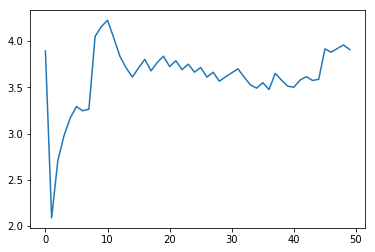

In [119]:
# for test
temp_x = group[['norm_area', 'norm_length', 'norm_num_of_corr', 'norm_A/L', 
                'norm_area quote', 'norm_convex area quote', 'norm_centroid x/width',
                'norm_centroid y/height', 'norm_width/height',
                's1', 's2', 's3', 's4', 's5', 's6', 'r1', 'r2']]#.values.reshape(1, -1)
x = []
temp_result = []
for i in range(50):
    sub_group = group.iloc[:i+1, :]
    mean = sub_group["score"].mean()
    max_x = np.max(sub_group["Left_down_x"].values)
    norm_max_x = np.max(sub_group["norm_left_down_x"].values)
    max_y = np.max(sub_group["Right_down_y"].values)

    area_quote = 1-sub_group["Area"].sum()/(max_x*max_y)
    temp_result.append(mean+area_quote+0.5*norm_max_x)
    x.append(mean+area_quote+0.5*norm_max_x)
plt.plot(x)
plt.show()

In [105]:
# read tmp result
result = pd.read_csv('../results/features_50labels.csv', index_col = 0)

In [106]:
result.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899
92600-1005_1,1.328,1.064,-0.193,1.315,-1.690,-1.739,-1.323,0.530,0.013,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,-1.281,-1.705,-0.916,-1.241,-0.173,-0.361,0.393,-1.568,-0.124,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.377,0.421,0.096,0.615,1.337,1.194,0.358,-0.429,-0.771,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,-0.920,-0.761,-0.482,-0.921,-0.018,0.989,1.181,-0.418,-0.499,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,-1.281,-1.705,-0.916,-1.241,-0.173,-0.361,0.393,-1.568,-0.124,1.000

In [110]:
train_x = result.iloc[:int(len(result)*0.9), :850].values.reshape(int(len(result)*0.9), 50, -1)
test_x = result.iloc[int(len(result)*0.9):, :850].values.reshape(len(result) - int(len(result)*0.9), 50, -1)

In [113]:
train_y = result.iloc[:int(len(result)*0.9), 850:].values.reshape(int(len(result)*0.9), 50, -1)
test_y = result.iloc[int(len(result)*0.9):, 850:].values.reshape(len(result) - int(len(result)*0.9), 50, -1)

In [115]:
# save to the local system
np.save('../data/rnn_train_x', train_x)
np.save('../data/rnn_train_y', train_y)
np.save('../data/rnn_test_x', test_x)
np.save('../data/rnn_test_y', test_y)

'../data/rnn_train_x.npy'

## bild the rnn model

In [139]:
"""
bild the model, loss and data class, including two different versions
version 1:
seq to seq model
versioin 2:
seq to 1 model
"""
class TS_rnn(torch.nn.Module):
    """
    scores for each piece
    input:
        tensor size of (batch_size, seq_len, num_dim)
    output:
        tensor size of (batch_size, seq_len)
    """
    def __init__(self):
        super(TS_rnn, self).__init__()
        #change the structure of the network
        num_inp = 17
        num_hidden = 64
        self.rnn = torch.nn.LSTM(input_size = num_inp, hidden_size = num_hidden, num_layers = 2)
        self.mlp = torch.nn.Sequential(
                torch.nn.Linear(num_hidden, 16),
                torch.nn.Dropout(),
                torch.nn.ReLU(),
                torch.nn.Linear(16, 1)
                )

    def forward(self, inp):
        # input of the rnn (seq_len, batch, input_size)
        data_in = torch.transpose(inp, 0, 1)
        # run rnn, it has two output
        out_rnn, _ = self.rnn(data_in)
        out_rnn = torch.transpose(out_rnn, 0, 1) # (batch_size, seq_len, num_dim)
        # rnn the mlp
        batch_size, seq_len, num_dim = out_rnn.shape
        out = []
        for i in range(seq_len):
            tmp = self.mlp(out_rnn[:, i,:])
            out.append(tmp)
        # now out is list of (batch_size, 1), combine the items in the list to get the output with size (batch_size, seq_len)
        out = torch.cat(out, 1)
        #return out.squeeze() when the batch_size == 1, this can course trouble
        return out

class TS_rnn2(torch.nn.Module):
    """
    scores only for the whole task
    input:
        tensor size of (batch_size, seq_len, num_dim)
    output:
        tensor size of (batch_size)
    """
    def __init__(self):
        super(TS_rnn2, self).__init__()
        #change the structure of the network
        num_inp = 8
        num_hidden = 64
        self.rnn = torch.nn.LSTM(input_size = num_inp, hidden_size = num_hidden, num_layers = 2)
        self.mlp = torch.nn.Sequential(
                torch.nn.Linear(num_hidden, 64),
                torch.nn.Dropout(),
                torch.nn.ReLU(),
                torch.nn.Linear(64, 1)
                )

    def forward(self, inp):
        # input of the rnn (seq_len, batch, input_size)
        data_in = torch.transpose(inp, 0, 1)
        # run rnn, it has two output
        out_rnn, _ = self.rnn(data_in)
        out_rnn = torch.transpose(out_rnn, 0, 1) # (batch_size, seq_len, num_dim)
        # only use the last output
        out_rnn = out_rnn[:, -1, :].squeeze()
        # rnn the mlp
        out = self.mlp(out_rnn)
        return out.squeeze()
    
class PDLoss(torch.nn.Module):
    def __init__(self, p = 2):
        super(PDLoss, self).__init__()
        self.pd = torch.nn.PairwiseDistance(p)

    def forward(self, o, t):
        # out: (batch_size, 1)
        out = self.pd(o, t)
        return out.mean()

class Data:
    """
    data class for TS_rnn
    """
    def __init__(self, x, y):
        self.data = {}
        self.data['train_x'] = self.add_file(x).float()
        self.data['train_y'] = self.add_file(y)[:, :, -1].float() # use the first metric tempately
        assert(len(self.data['train_x']) == len(self.data['train_y']))
        self.len = len(self.data['train_x'])

    def add_file(self, path):
        return torch.from_numpy(np.load(path))

    def add_scores(self, path):
        return torch.FloatTensor([float(li.rstrip('\n')) for li in open(path)])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return (self.data['train_x'][index],
                self.data['train_y'][index])

class Data2:
    """
    data class for TS_rnn2
    """
    def __init__(self, x, y):
        self.data = {}
        self.data['train_x'] = self.add_file(x)
        self.data['train_y'] = self.add_file(y)[:, :, -1] # use the first metric tempately
        self.data['train_y'] = torch.mean(self.data['train_y'], 1)
        assert(len(self.data['train_x']) == len(self.data['train_y']))
        self.len = len(self.data['train_x'])

    def add_file(self, path):
        return torch.from_numpy(np.load(path))

    def add_scores(self, path):
        return torch.FloatTensor([float(li.rstrip('\n')) for li in open(path)])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return (self.data['train_x'][index],
                self.data['train_y'][index])

In [146]:
# write the test function
def test_model(dl_test, model, loss):
    model.eval()
    test_loss = 0
    counter = 0
    for batch_idx, dat in enumerate(dl_test):
        counter += 1
        # codes to be changed
        inp, target = dat
        out = model(inp)
        lo = loss(out, target)
        test_loss += lo.data
    return test_loss/counter

def significant_test(dl_test, model, loss):
    model.eval()
    test_loss = 0
    counter = 0
    hit = 0
    miss = 0
    for batch_idx, dat in enumerate(dl_test):
        counter += 1
        # codes to be changed
        inp, target = dat
        out = model(inp)
        target = target.mean(dim = 1)
        #print(out.shape)
        out = out.mean(dim = 1)
        #print(out.shape)
        if len(inp) > 5:
            _, top_target = torch.topk(target, 1)
            _, top_predict = torch.topk(out, 5)
            if top_target in top_predict:
                hit += 1
            else:
                miss += 1
    return hit * 1.0/(hit + miss)

In [147]:
# run the model
train_x = '../data/rnn_train_x.npy'
train_y = '../data/rnn_train_y.npy'
test_x = '../data/rnn_test_x.npy'
test_y = '../data/rnn_test_y.npy'
num_epochs = 100
batch_size = 30
verbose = True
# set models and loss
model = TS_rnn()
#loss = PDLoss()
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
# set the scheduler
lamb1 = lambda x: .1**(x//30)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = lamb1)
# loda data
train = Data(train_x, train_y)
test = Data(test_x, test_y)
dl_train = DataLoader(train, batch_size = batch_size, shuffle = True)
dl_test = DataLoader(test, batch_size = batch_size, shuffle = True)
# train the model
for epoch in range(num_epochs):
    scheduler.step()
    model.train()
    train_loss = 0
    counter = 0
    for batch_idx, dat in enumerate(dl_train):
        counter += 1
        # train the model
        optimizer.zero_grad()
        inp, target = dat
        out = model(inp)
        lo = loss(out, target)
        lo.backward()
        optimizer.step()
        train_loss += lo.data
        if verbose:
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * batch_size,
                    len(train),
                    100.*batch_idx*batch_size/len(train),
                    lo.data
                    ))
    test_lo = test_model(dl_test, model, loss)
    hit_rate = significant_test(dl_test, model, loss)
    if verbose:
        # train loss
        print('====> Epoch: {} Average train loss: {:.4f}'.format(
            epoch,
            train_loss/counter
            ))
        # test loss
        print('====> Epoch: {} Average test loss: {:.4f}'.format(
            epoch,
            test_lo
            ))
        # significant test
        print('====> Epoch: {} Average hit rate in 10 candidate: {: .4f}'.format(
            epoch,
            hit_rate
        ))

Train Epoch: 0 [0/13771 (0%)]	Loss: 2.945713
Train Epoch: 0 [300/13771 (2%)]	Loss: 2.735838
Train Epoch: 0 [600/13771 (4%)]	Loss: 2.193754
Train Epoch: 0 [900/13771 (7%)]	Loss: 1.234544
Train Epoch: 0 [1200/13771 (9%)]	Loss: 1.194532
Train Epoch: 0 [1500/13771 (11%)]	Loss: 1.161489
Train Epoch: 0 [1800/13771 (13%)]	Loss: 1.063485
Train Epoch: 0 [2100/13771 (15%)]	Loss: 1.093979
Train Epoch: 0 [2400/13771 (17%)]	Loss: 1.097558
Train Epoch: 0 [2700/13771 (20%)]	Loss: 1.098471
Train Epoch: 0 [3000/13771 (22%)]	Loss: 1.077084
Train Epoch: 0 [3300/13771 (24%)]	Loss: 1.087945
Train Epoch: 0 [3600/13771 (26%)]	Loss: 1.090444
Train Epoch: 0 [3900/13771 (28%)]	Loss: 1.047425
Train Epoch: 0 [4200/13771 (30%)]	Loss: 1.112752
Train Epoch: 0 [4500/13771 (33%)]	Loss: 1.090375
Train Epoch: 0 [4800/13771 (35%)]	Loss: 1.051500
Train Epoch: 0 [5100/13771 (37%)]	Loss: 1.038006
Train Epoch: 0 [5400/13771 (39%)]	Loss: 1.051139
Train Epoch: 0 [5700/13771 (41%)]	Loss: 1.057357
Train Epoch: 0 [6000/13771 (44%

KeyboardInterrupt: 

In [39]:
# save model
torch.save(model, '../models/rnn_predict.pkl')

/anaconda3/envs/data_mining/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type TS_rnn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
#?? how to get the weight of a mlp model in pytorch

In [157]:
mod = torch.nn.LSTM(input_size = 17, hidden_size = 64, num_layers = 3, dropout = 0.5)

In [173]:
parms = model.mlp.

In [176]:
parms.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [68]:
c = np.load('../data/rnn_train_y.npy')
c = torch.from_numpy(c)

In [181]:
a = torch.FloatTensor([3,2,3,2])
b = torch.FloatTensor([3,2,4,5])

In [190]:
c = torch.stack([a, b], dim = 0)

In [193]:
torch.std(c, dim = 1)

tensor([0.5774, 1.2910])

In [198]:
lamb1 = lambda x: 0.01 * 0.1**((x%100)//30)

In [206]:
lamb1(122)

0.01

In [205]:
pdist = torch.nn.PairwiseDistance(p=2)

In [206]:
a1 = torch.randn(4, 2)
a2 = torch.randn(4,2)

In [251]:
torch.mean(a1, 1)

tensor([-0.0431,  0.7919,  1.5557,  0.3310])

In [252]:
a1

tensor([[ 0.5227, -0.6088],
        [ 0.5556,  1.0283],
        [ 1.5431,  1.5683],
        [ 0.5531,  0.1089]])

In [211]:
a

tensor([1.6103, 2.5548, 3.8726, 3.3924])

In [17]:
a = [1,2,3,4,5,6]

In [21]:
random.shuffle(a)

In [22]:
a

[6, 3, 2, 1, 5, 4]

In [34]:
df['Metric2'].value_counts()

1.0       176215
2.0        38878
3.0        21295
83.0       20960
43.0       13990
158.0      13009
84.0       10989
125.0      10989
167.0       9990
217.0       7992
663.0       7992
622.0       7992
408.0       6993
240.0       6016
137.0       5995
561.0       5994
443.0       5994
124.0       5994
57.0        5994
279.0       5994
647.0       5994
165.0       5975
160.0       5372
94.0        5028
774.0       5017
249.0       4995
745.0       4995
692.0       4995
138.0       4995
119.0       4983
           ...  
80.0           4
1666.0         4
923.0          4
1226.0         4
1678.0         4
1139.0         4
873.0          4
163.0          4
1051.0         4
726.0          4
90.0           2
427.0          1
154.0          1
415.0          1
251.0          1
210.0          1
278.0          1
1638.0         1
495.0          1
1595.0         1
1592.0         1
1575.0         1
799.0          1
967.0          1
825.0          1
845.0          1
879.0          1
333.0         

In [ ]:
#
area_quote_6 = polygon6.area/(polygon6.bounds[2]*polygon6.bounds[3])
#
convex_hull_x, convex_hull_y = [z.tolist() for z in polygon6.convex_hull.exterior.coords.xy]
convex_polygon6 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_6 = convex_polygon6.area/(convex_polygon6.bounds[2]*convex_polygon6.bounds[3])
# 
print("the area use quote is : " , area_quote_6)
print("the area use quote of convex is : " , convex_area_quote_6)
print("the number of ecke :" , len(polygon6.boundary.coords))
print(polygon6.centroid)


area_quote_5 = polygon5.area/(polygon5.bounds[2]*polygon5.bounds[3])

convex_hull_x, convex_hull_y = [z.tolist() for z in polygon5.convex_hull.exterior.coords.xy]
convex_polygon5 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_5 = convex_polygon5.area/(convex_polygon5.bounds[2]*convex_polygon5.bounds[3])

print("the area use quote is : " , area_quote_5)
print("the area use quote of convex is : " , convex_area_quote_5)
print("the number of ecke :" , len(polygon5.boundary.coords))


area_quote_4 = polygon4.area/(polygon4.bounds[2]*polygon4.bounds[3])

convex_hull_x, convex_hull_y = [z.tolist() for z in polygon4.convex_hull.exterior.coords.xy]
convex_polygon4 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_4 = convex_polygon4.area/(convex_polygon4.bounds[2]*convex_polygon4.bounds[3])

print("the area use quote is : " , area_quote_4)
print("the area use quote of convex is : " , convex_area_quote_4)
print("the number of ecke :" , len(polygon4.boundary.coords))

area_quote_3 = polygon3.area/(polygon3.bounds[2]*polygon3.bounds[3])

convex_hull_x, convex_hull_y = [z.tolist() for z in polygon3.convex_hull.exterior.coords.xy]
convex_polygon3 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_3 = convex_polygon3.area/(convex_polygon3.bounds[2]*convex_polygon3.bounds[3])


print("the area use quote is : " , area_quote_3)
print("the area use quote of convex is : " , convex_area_quote_3)
print("the number of ecke :" , len(polygon3.boundary.coords))

area_quote_2 = polygon2.area/(polygon2.bounds[2]*polygon2.bounds[3])

convex_hull_x, convex_hull_y = [z.tolist() for z in polygon2.convex_hull.exterior.coords.xy]
convex_polygon2 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_2 = convex_polygon2.area/(convex_polygon2.bounds[2]*convex_polygon2.bounds[3])


print("the area use quote is : " , area_quote_2)
print("the area use quote of convex is : " , convex_area_quote_2)
print("the number of ecke :" , len(polygon2.boundary.coords))


area_quote_1 = polygon1.area/(polygon1.bounds[2]*polygon1.bounds[3])

convex_hull_x, convex_hull_y = [z.tolist() for z in polygon1.convex_hull.exterior.coords.xy]
convex_polygon1 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_1 = convex_polygon1.area/(convex_polygon1.bounds[2]*convex_polygon1.bounds[3])


print("the area use quote is : " , area_quote_1)
print("the area use quote of convex is : " , convex_area_quote_1)


a = [[polygon6, area_quote_6, convex_area_quote_6, polygon6.centroid.x, polygon6.centroid.y, convex_polygon6.bounds[2]/convex_polygon6.bounds[3]],
    [polygon5, area_quote_5, convex_area_quote_5, polygon5.centroid.x, polygon5.centroid.y, convex_polygon5.bounds[2]/convex_polygon5.bounds[3]],
    [polygon4, area_quote_4, convex_area_quote_4, polygon4.centroid.x, polygon4.centroid.y, convex_polygon4.bounds[2]/convex_polygon4.bounds[3]],
    [polygon3, area_quote_3, convex_area_quote_3, polygon3.centroid.x, polygon3.centroid.y, convex_polygon3.bounds[2]/convex_polygon3.bounds[3]],
    [polygon6, area_quote_2, convex_area_quote_2, polygon2.centroid.x, polygon2.centroid.y, convex_polygon2.bounds[2]/convex_polygon2.bounds[3]],
    [polygon6, area_quote_1, convex_area_quote_1, polygon1.centroid.x, polygon1.centroid.y, convex_polygon1.bounds[2]/convex_polygon1.bounds[3]]]

